Here is my analysis within an API makeup dataset (https://makeup-api.herokuapp.com/api/v1/products.json). My questions for this dataset was "Which company has the most affordable vegan products?" My goals for this dataset were 1) creating user-interactive scatterplots 2) overall trend scatterplots 3) bar graphs

In [1]:
import json 
import pandas as pd 
import numpy as np 
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", None)

In [2]:
with open("/Users/jessicanguyen/Desktop/Coding Projects/makeup_api_heroku.json") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(columns = ["Product Type","Product Tags","Brand","Price", "Currency", "Description","Rating","Product Link"])

In [4]:
for i in range(0,len(data)):
    currentItem = data[i]
    df.loc[i] = [data[i]["product_type"],data[i]["tag_list"],data[i]["brand"],data[i]["price"], data[i]["currency"],data[i]["description"],data[i]["rating"],data[i]["product_link"]]

1) Data had missing values. The way I solved this issue was by filling all the values with NA which would then be replaced with default values later in the code.

In [5]:
df.fillna(method='ffill', inplace=True)

2) While cleaning this data was that there were different currencies within the data (USD, CAD,GDP). How I solve this was converting all currencies to USD. 

In [6]:
for i in range(0,len(data)):
    if data[i]["currency"] == "CAD":
        Converted_Price = (float(data[i]["price"])*1.146)
        df["Price"] = df["Price"].replace([data[i]["price"]],Converted_Price)
        df = df.replace('CAD','USD')
    if data[i]["currency"] == "GBP":
        Converted_Price = (float(data[i]["price"])*1.3603)
        df["Price"] = df["Price"].replace([data[i]["price"]],Converted_Price)
        df = df.replace('GBP','USD')

df = df.replace('USD','USD')

In [7]:
df['Price'] = df['Price'].astype(float)
df = df.sort_values(by = ['Price'])

3) The issue of having missing NA values for the currency column led to me having to fill the value with "USD". This is an assumption made that everything with a price but no currency will become USD.

In [8]:
for i in range(0,len(data)):
    if type(data[i]['currency']) == type(None):
        df['Currency'] = df['Currency'].replace([data[i]["currency"]],'USD')

4) Another issue was that there were missing prices that had 0 dollars. An assumption that was made was that products that costed $0 would be irrelevant products and did not need to be included in the dataset.

In [9]:
df = df.loc[df['Price'] != 0.00000]

In [10]:
Plist = list(df["Product Type"])
Plist = list(set(Plist))

In [11]:
Blist = list(df["Brand"])
Blist = list(set(Blist))

In [12]:
import ipywidgets as widgets
from matplotlib import pyplot as plt 
import matplotlib
import mplcursors

In [13]:
np.random.seed(seed = 30)
cmap = matplotlib.cm.get_cmap('Spectral')
color_dict = pd.Series({k:cmap(np.random.rand()) for k in df['Brand'].unique()})
color_dict.name = 'color_dict'
df = pd.merge(df,color_dict,how = 'left',left_on = 'Brand',right_index = True)

5) Regarding the NA values that are within the rating column and price column, there were two assumptions/weaknesses that were made. Everything that has no rating got the default average rating of that product. For instance: if there is a lipstick from glossier with 'NA' in the rating column, the 'NA' would be replaced with the average rating of all lipsticks in the dataset. The same assumption was made for the 'NA' values in the price column.

In [80]:
def productscatter(producttype, brand): 
    x_points = []
    y_points = []
    use = df.loc[df['Product Type'] == producttype]
    xname = 'Ratings of ' + brand 
    yname = 'Price of ' + brand
    titname = 'The Relationship between Ratings and Prices of ' + producttype
    
    lr = list((use['Rating']))
    lr_modified = []
    for i in range (len(lr)):
        if lr[i] >= 0:
            lr_modified.append(lr[i])
            
    lp = list((use['Price']))
    lp_modified = []
    for i in range (len(lp)):
        if lp[i] >= 0:
            lp_modified.append(lp[i])
    
    if len(lr_modified) == 0: #for eyebrow rating
        lr_modified = lr
        use['Rating'] = use['Rating'].fillna(value= 4)
    else:
        average = sum(lr_modified) / len(lr_modified)
        averageprice = sum(lp_modified) / len(lp_modified)
        use['Rating'] = use['Rating'].fillna(value=average)
        use['Price'] = use['Price'].fillna(value=averageprice)
        
    x_points = list(use['Rating'])
    y_points = list(use['Price'])

    useb = use.loc[use['Brand'] == brand]
    useb_ratings = list(useb['Rating'])
    useb_price = list(useb['Price'])
    
    if len(useb_ratings) == 0:
        unavail = "There is no " +producttype + " listed under this brand: " + brand
        plt.scatter(useb_ratings,useb_price, c = useb['color_dict'])
        plt.text(-0.05,0.02,unavail, fontsize = 10, bbox = {'facecolor':'pink', 'alpha':0.3})
    else:
        plt.scatter(useb_ratings,useb_price, c = useb['color_dict'])
    plt.xlabel(xname, fontsize = 15)
    plt.ylabel(yname, fontsize = 15)
    plt.title(titname, fontsize = 20)
    

Through this interactive scatterplot, the user is able to see how specific products within specific brands compare to each other. This is a demonstration of how I'm able to integrate user interactions within the data visualization. 

In [81]:
widgets.interact(productscatter,producttype = Plist, brand = Blist)

interactive(children=(Dropdown(description='producttype', options=('eyeshadow', 'eyeliner', 'nail_polish', 'fo…

<function __main__.productscatter(producttype, brand)>

In [78]:
def overallproductscatter(producttype): 
    x_points = []
    y_points = []
    use = df.loc[df['Product Type'] == producttype]
    xname = 'Ratings of ' + producttype
    yname = 'Price of ' + producttype
    titname = 'The Relationship between Ratings and Prices of ' + producttype
    
    lr = list((use['Rating']))
    lr_modified = []
    for i in range (len(lr)):
        if lr[i] >= 0:
            lr_modified.append(lr[i])
            
    lp = list((use['Price']))
    lp_modified = []
    for i in range (len(lp)):
        if lp[i] >= 0:
            lp_modified.append(lp[i])
    
    if len(lr_modified) == 0: #for eyebrow rating
        lr_modified = lr
        use['Rating'] = use['Rating'].fillna(value= 4)
    else:
        average = sum(lr_modified) / len(lr_modified)
        averageprice = sum(lp_modified) / len(lp_modified)
        use['Rating'] = use['Rating'].fillna(value=average)
        use['Price'] = use['Price'].fillna(value=averageprice)
        
    x_points = list(use['Rating'])
    y_points = list(use['Price'])

    plt.scatter(x_points,y_points, c = use['color_dict'])
    plt.xlabel(xname, fontsize = 15)
    plt.ylabel(yname, fontsize = 15)
    plt.title(titname, fontsize = 20)


 Here is another interactive scatterplot with only one parameter (selected product type). This allows the user to see the trends of ratings/price of the mascara and even gives them insight on which brand will fluctuate in which regions. Ways this scatterplot can be improved is by including a legend for the graph to show which companies are which colors. I tried to allow the user to figure out through the interactive scatterplot on the top, but I would like to learn how to create a legend based on a dictionary.

In [79]:
widgets.interact(overallproductscatter,producttype = Plist)

interactive(children=(Dropdown(description='producttype', options=('eyeshadow', 'eyeliner', 'nail_polish', 'fo…

<function __main__.overallproductscatter(producttype)>

In [18]:
lindex = []
v = []
count = 0
q = 0
pt = dict(df['Product Tags'])
pt_k = list(pt.keys())

for i in pt:
    if 'Vegan' in pt[i]:
        v.append(i)

for i in range(len(pt_k)):
    if count > 60:
        break
    elif pt_k[i] == v[count]:
        lindex.append(q)
        count = count + 1
    q = q + 1


In [19]:
vegan = pd.DataFrame()

for i in lindex:
    vproduct = df.iloc[i]
    vegan = vegan.append(vproduct,ignore_index = True)


Here, I am attempting to create the bar graph that has all the brand products starting with e.l.f. and ending with pacifica. The reason why the graph is left skewed is because I organized the data to have the prices in increasing order. However, this is not very informative which is why I simplified by using the average prices of the brand on the x-axis in the next graph.

<AxesSubplot:xlabel='Brand'>

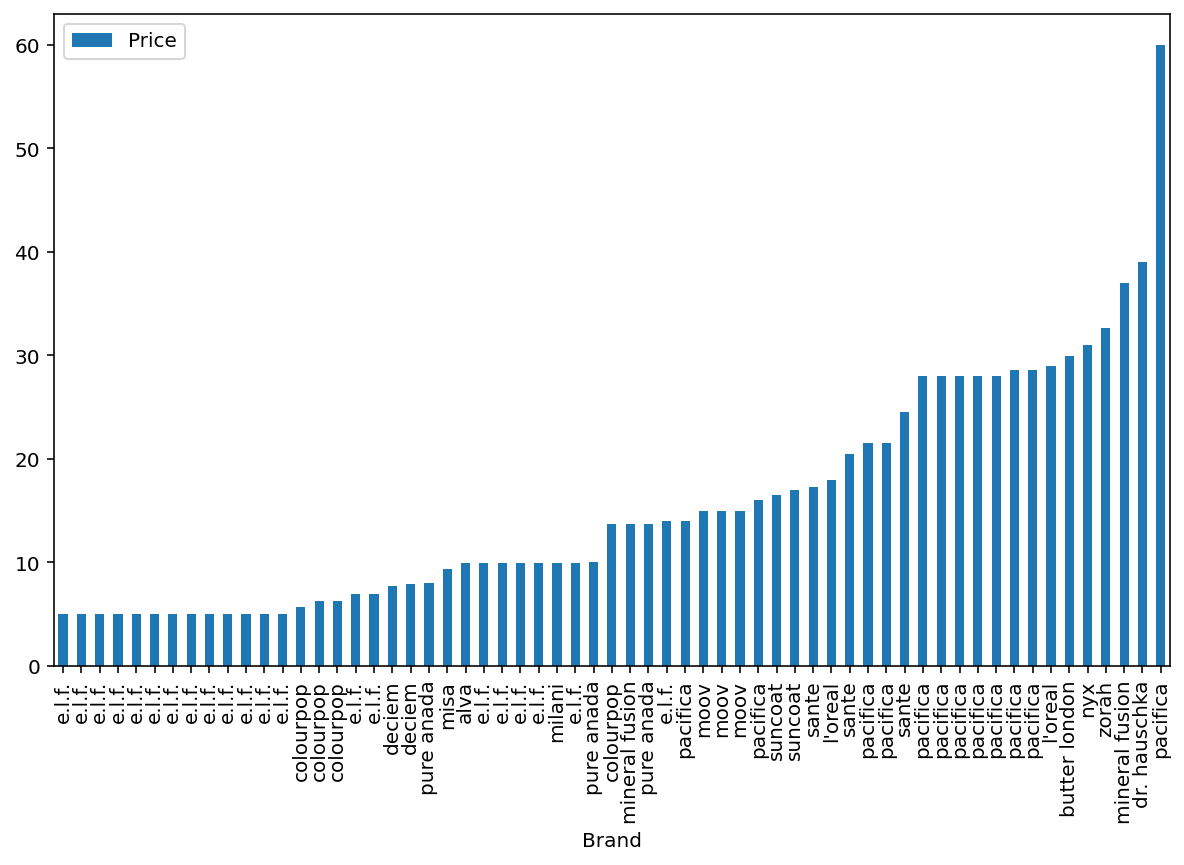

In [20]:
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'
vegan.plot.bar(x='Brand', y='Price')

In [ ]:
Here gives us better insight on the most affordable vegan products within the brands included in the dataset. The most affordable brand is e.l.f. 

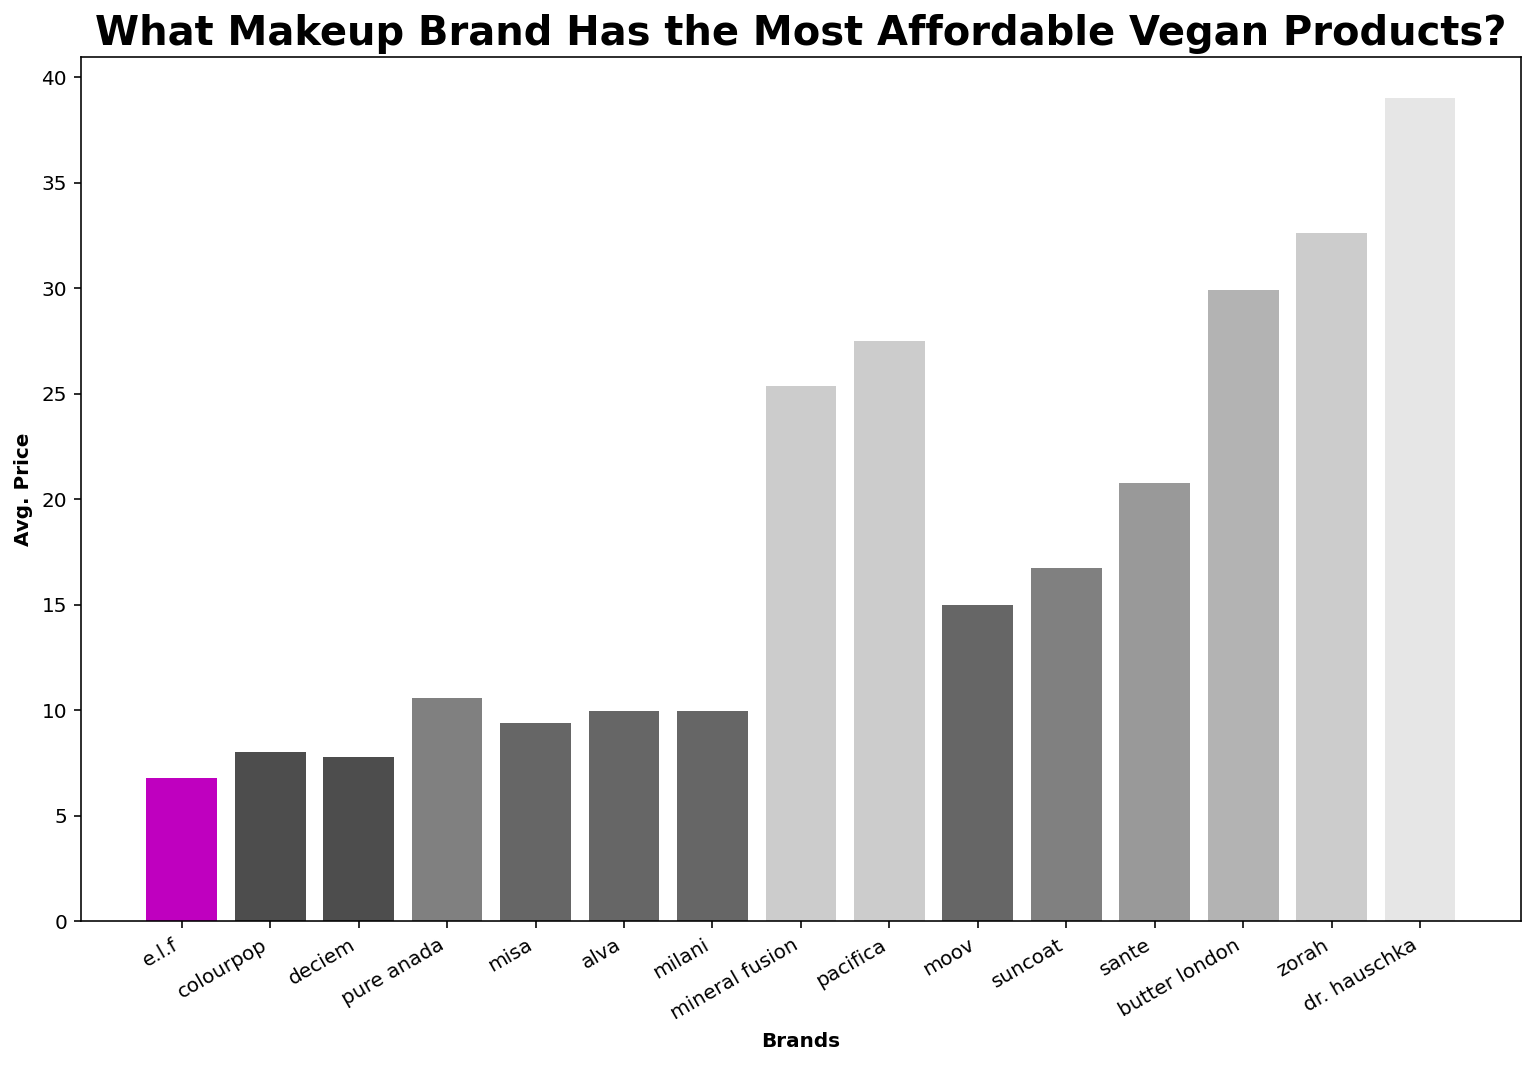

In [69]:
elf = vegan.loc[vegan['Brand'] == 'e.l.f.']
cpop = vegan.loc[vegan['Brand'] == 'colourpop']
deciem = vegan.loc[vegan['Brand'] == 'deciem']
panada = vegan.loc[vegan['Brand'] == 'pure anada']
misa = vegan.loc[vegan['Brand'] == 'misa']
alva = vegan.loc[vegan['Brand'] == 'alva']
milani = vegan.loc[vegan['Brand'] == 'milani']
mineralfusion = vegan.loc[vegan['Brand'] == 'mineral fusion']
pacifica = vegan.loc[vegan['Brand'] == 'pacifica']
moov = vegan.loc[vegan['Brand'] == 'moov']
suncoat = vegan.loc[vegan['Brand'] == 'suncoat']
sante = vegan.loc[vegan['Brand'] == 'sante']
butterlondon = vegan.loc[vegan['Brand'] == 'butter london']
zorah = vegan.loc[vegan['Brand'] == 'zorah']
drhauschka = vegan.loc[vegan['Brand'] == 'dr. hauschka']

columnbrands = ['e.l.f', 'colourpop', 'deciem', 'pure anada', 'misa','alva','milani','mineral fusion', 'pacifica', 'moov', 'suncoat', 'sante', 'butter london', 'zorah', 'dr. hauschka']
datasets = [elf,cpop,deciem,panada,misa,alva,milani,mineralfusion,pacifica, moov,suncoat,sante,butterlondon,zorah,drhauschka]
yt = []

def avgprice(dataset):
    average = sum(list(dataset['Price'])) / len(list(dataset['Price']))
    return average

for i in range(len(datasets)):
    y_coor = avgprice(datasets[i])
    yt.append(y_coor)

colors = ['m','.3','.3','.5','.4','.4','.4','.8','.8','.4','.5','.6','.7','.8','.9','.9']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(columnbrands,yt, color=colors)
plt.xlabel('Brands',fontweight='bold')
plt.ylabel('Avg. Price',fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('What Makeup Brand Has the Most Affordable Vegan Products?', fontweight = 'bold', fontsize = 20)
plt.show()

In [59]:
print("The average price for vegan e.l.f. products is", avgprice(elf))

The average price for vegan e.l.f. products is 6.7995238095238095
